<a href="https://colab.research.google.com/github/Sen-R/deep-generative-models/blob/master/notebooks/FVSBNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this notebook we implement a [Fully Visible Sigmoid Belief Network](http://proceedings.mlr.press/v38/gan15.pdf) (FVSBN) to model images in the [Binarized MNIST](https://www.cs.toronto.edu/~rsalakhu/papers/dbn_ais.pdf) digits dataset (available on [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/binarized_mnist)).

We will define and train the model, and then visualise both conditional distributions and samples drawn from the model.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

# Load and prepare the data

In [2]:
train = tfds.load("binarized_mnist", split="train", try_gcs=True)
test = tfds.load("binarized_mnist", split="test", try_gcs=True)

def autoencoding_transform(data):
    return data["image"], data["image"]

BATCH_SIZE = 1024
batch_train = train.cache().batch(BATCH_SIZE).map(autoencoding_transform, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
batch_test = test.cache().batch(BATCH_SIZE).map(autoencoding_transform, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/binarized_mnist/1.0.0.incompleteKJ4AY7/binarized_mnist-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/binarized_mnist/1.0.0.incompleteKJ4AY7/binarized_mnist-validation.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/binarized_mnist/1.0.0.incompleteKJ4AY7/binarized_mnist-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset binarized_mnist downloaded and prepared to /root/tensorflow_datasets/binarized_mnist/1.0.0. Subsequent calls will reuse this data.


Here we define and use a helper function for visualising images from the dataset:

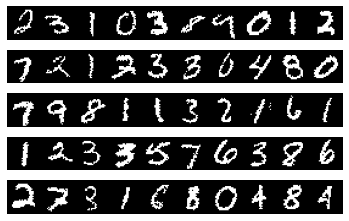

In [22]:
def show_examples(data, examples=50, ncols=10, **kwargs):
    if not hasattr(data, "shape"):
        # See if it is a tuple, dict or dataset and convert if possible.
        if hasattr(data, "keys"):
            show_examples(data["image"], examples, ncols, **kwargs)
        elif isinstance(data, tuple):
            show_examples(data[0], examples, ncols, **kwargs)
        else:  # Assume it's a dataset
            show_examples(next(iter(data)), examples, ncols, **kwargs)
    else:
        if hasattr(data, "numpy"):
            # Convert tensors to numpy
            data = data.numpy()
        examples = min(examples, len(data))
        nrows = math.ceil(examples / ncols)
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, **kwargs)
        for image, ax in zip(data, axs.flatten()):
            ax.imshow(image.squeeze(), cmap="gist_gray")
            ax.axis("off")
        fig.subplots_adjust(wspace=0, hspace=0)
        plt.show()

show_examples(batch_train.shuffle(1000))


# Define the model

We subclass `tf.keras.Model` to define the FVSBN. See the paper referenced in the introduction (or these [lecture notes](https://deepgenerativemodels.github.io/assets/slides/cs236_lecture3.pdf)) for an explanation of its design.

In [18]:
class FVSBN(tf.keras.Model):
    def __init__(
        self,
        input_shape,
        activation="sigmoid",
        bias_initializer="glorot_uniform",
        kernel_initializer="glorot_uniform",
    ):
        super().__init__()
        self.activation = tf.keras.activations.get(activation)
        self.bias_initializer = tf.keras.initializers.get(bias_initializer)
        self.kernel_initializer = tf.keras.initializers.get(kernel_initializer)
        self.dims = tf.reduce_prod(input_shape)
        self.reconstructed_dims = input_shape
        self.mask = 1. - tf.linalg.band_part(
            tf.ones((self.dims, self.dims), dtype=tf.float32), -1, 0
        )
        self.bias = tf.Variable(
            name="bias",
            initial_value=self.bias_initializer(
                shape=(self.dims,), dtype=tf.float32
            ),
            trainable=True,
        )
        self.kernel = tf.Variable(
            name="kernel",
            initial_value=self.kernel_initializer(
                shape=(self.dims, self.dims), dtype=tf.float32
            ),
            trainable=True,
        )

    @tf.function(
        input_signature=(tf.TensorSpec(shape=[None, None], dtype=tf.float32),)
    )
    def single_pass_probs(self, x):
        """Return just the conditional probabilities that can be immediately
        calculated given inputs `x`.

        If `x` consists of a batch of observations for the first `i` variables
        being modelled (i.e. has shape `(batch_size, i)`), then this function
        outputs $$p(x_j | x_0 \ldots \_{j-1})$$ for $$j=0, 1, \ldots (i+1)$$.
        The exception is when `i == self.dims` in which case, the output is
        the same shape as the input.
        """
        i = tf.shape(x)[-1]
        d = i + 1  # Target size for output, capped at self.dims
        trunc_kernel = (self.kernel * self.mask)[:i, :d]
        trunc_bias = self.bias[:d]
        return self.activation(
            tf.matmul(x, trunc_kernel) + trunc_bias
        )

    def call(self, inputs):
        """Operate the model in "autoencoder" mode.

        I.e. given an input image, produce a full set of conditional
        probabilities, preserving the auto-regressive structure of the model
        (when viewed as an auto-encoder).
        """
        orig_shape = tf.shape(inputs)
        x = tf.reshape(tf.cast(inputs, tf.float32), [-1, self.dims])
        probs = self.single_pass_probs(x)
        return tf.reshape(probs, orig_shape)

    def sample(self, n, cond=None):
        """Draw `n` samples from the model distribution.
        
        `cond` allows sampling conditional on the first `i` observations;
        `cond` must have shape `(n, i)` where `i <= self.dims`. Set `cond`
        to `None` (the default) for unconditional sampling.
        """
        if cond is None:
            sample = tf.zeros(shape=(n, 0), dtype=tf.float32)
        else:
            cond = tf.reshape(cond, [tf.shape(cond)[0], -1])
            if cond.shape[0] != n or cond.shape[1] > self.dims:
                raise ValueError(f"Invalid shape for `cond`: {cond.shape}")
            sample = tf.cast(cond, tf.float32)
        for i in range(self.dims - sample.shape[-1]):
            all_probs = self.single_pass_probs(sample)
            sample_probs = all_probs[:, -1:]
            draws = tf.cast(
                tf.random.uniform((n, 1)) < sample_probs,
                dtype=tf.float32,
            )
            sample = tf.concat([sample, draws], axis=1)
        return tf.reshape(
            tf.cast(sample, tf.uint8),
            [n] + list(self.reconstructed_dims),
        )


We now create and compile the model, ready for training:

In [19]:
tf.keras.backend.clear_session()
model = FVSBN(input_shape=(28, 28, 1))
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01),
    loss=tf.keras.losses.BinaryCrossentropy(),
)
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(verbose=1, min_delta=1e-5, factor=0.3),
    tf.keras.callbacks.EarlyStopping(patience=5),
]

# Model training

Next we train the model. If the weights have already been savd, run the next cell to reload them and skip training:

In [20]:
# Run this cell if you've previously trained the model and run the save weights
# cell below
!bzip2 -d fvsbn_weights.tar.bz2
!tar xvf fvsbn_weights.tar
model.load_weights("trained_weights")

bzip2: Can't open input file fvsbn_weights.tar.bz2: No such file or directory.
checkpoint
trained_weights.data-00000-of-00001
trained_weights.index


Otherwise, run the following cell to perform training:

In [ ]:
history = model.fit(batch_train, epochs=500, validation_data=batch_test, callbacks=[callbacks])

Epoch 1/500
49/49 [==============================] - 2s 29ms/step - loss: 0.3410 - val_loss: 0.2676
Epoch 2/500
49/49 [==============================] - 0s 8ms/step - loss: 0.2437 - val_loss: 0.2209
Epoch 3/500
49/49 [==============================] - 0s 8ms/step - loss: 0.2077 - val_loss: 0.1939
Epoch 4/500
49/49 [==============================] - 0s 8ms/step - loss: 0.1856 - val_loss: 0.1766
Epoch 5/500
49/49 [==============================] - 0s 8ms/step - loss: 0.1709 - val_loss: 0.1648
Epoch 6/500
49/49 [==============================] - 0s 8ms/step - loss: 0.1608 - val_loss: 0.1565
Epoch 7/500
49/49 [==============================] - 0s 8ms/step - loss: 0.1535 - val_loss: 0.1505
Epoch 8/500
49/49 [==============================] - 0s 7ms/step - loss: 0.1481 - val_loss: 0.1460
Epoch 9/500
49/49 [==============================] - 0s 8ms/step - loss: 0.1440 - val_loss: 0.1426
Epoch 10/500
49/49 [==============================] - 0s 7ms/step - loss: 0.1409 - val_loss: 0.1400
Epoch 11

Run the next cell to save the trained weights. If running this notebook on Colab, you can download the zipped tar so that it can be reuploaded to a new runtime while skipping retraining.

In [ ]:
# Only run this cell to save the trained weights
model.save_weights("trained_weights")
!tar cvf fvsbn_weights.tar checkpoint trained_weights.*
!bzip2 fvsbn_weights.tar

# Results

First, let's run the model in "autoencoder" mode, i.e. we send the original images as inputs and examine the models outputs, which represent the conditional probability of each pixel, conditioned on all preceding pixels:

Original:


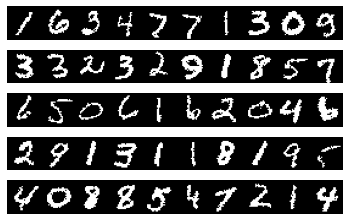

Conditional probabilities:


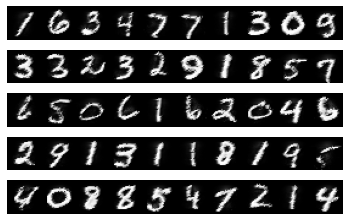

In [10]:
sample = next(iter(test.shuffle(1000).batch(50)))["image"]
print("Original:")
show_examples(sample)
plt.show()
print("Conditional probabilities:")
show_examples(model(sample))

Next, let us generate some (unconditional) samples from the trained model. Note the vaguely numeral-like forms:

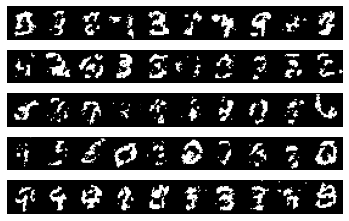

In [11]:
show_examples(model.sample(50))

**TODO:** next we feed the network partially occluded images (where the first part of a raster-scan of the image is available and the second part is missing) to see how well it is able to fill in the missing pixels.

Original inputs (showing occlusion):


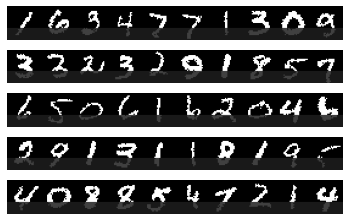


Occluded inputs:


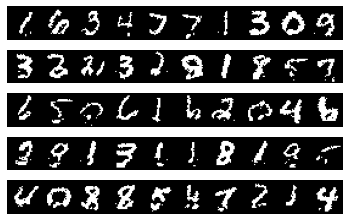

In [25]:
occ_line = 18
print("Original inputs (showing occlusion):")
occluded_sample = tf.concat(
    [
        tf.cast(sample[:, :occ_line, :, :], tf.float32),
        tf.cast(sample[:, occ_line:, :, :], tf.float32) * 0.15 + 0.1,
    ],
    axis=1,
)
show_examples(occluded_sample)
print("\nOccluded inputs:")
show_examples(model.sample(sample.shape[0], cond=sample[:, :occ_line, :, :]))